In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import json

from collections import defaultdict, Counter
from torch.utils.data import DataLoader
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)
device

device(type='cuda')

In [ ]:
def normalize_parameters(loader, num_channels):
    mean = torch.zeros(num_channels)
    std = torch.zeros(num_channels)
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        for channel in range(num_channels):
            mean[channel] += images[:, channel, :, :].mean().item()
        total_images += batch_samples

    mean /= total_images

    variance = torch.zeros(num_channels)
    for images, _ in loader:
        batch_samples = images.size(0)
        for channel in range(num_channels):
            variance[channel] += ((images[:, channel, :, :] - mean[channel]) ** 2).mean().item()

    variance /= total_images
    std = variance ** .5

    return mean.tolist(), std.tolist()

# **Dataset EMNIST**

In [11]:
train_dataset = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)

mean, std = normalize_parameters(train_loader, num_channels=1)

In [4]:
len_dataset = train_dataset.__len__()
batch_size = 16
total_steps = len_dataset // batch_size
learning_rate = .0005
num_classes = train_dataset.classes.__len__()
num_epochs = 5

In [16]:
print(train_dataset.classes[:15])
print(train_dataset.classes.__len__())
print(train_dataset.targets[:15])
print(train_dataset.targets.__len__())
print(train_dataset[0][0].shape)
print(mean, std)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E']
47
tensor([45, 36, 43, 15,  4, 42, 26, 32, 20,  1, 46, 43, 15, 13, 24])
112800
torch.Size([1, 28, 28])
[0.00017541879788041115] [0.011912137269973755]


# **utils**

In [5]:
def get_model(model_name, num_classes, ngpu = 2, requires_grad=False):
    if model_name == "resnet18":
        model = models.resnet18(weights="DEFAULT")
        model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        for param in model.parameters():
            param.requires_grad = True if requires_grad else False

        for param in model.fc.parameters():
            param.requires_grad = True
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "vgg16":
        model = models.vgg16(weights="DEFAULT")
        model.features[0] = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        for param in model.features.parameters():
            param.requires_grad = True if requires_grad else False

        for param in model.classifier.parameters():
            param.requires_grad = True
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "inception_v3":
        model = models.inception_v3(weights="DEFAULT", aux_logits=True)
        model.Conv2d_1a_3x3.conv = nn.Conv2d(3, 32, kernel_size=3, stride=2, bias=False)

        for param in model.parameters():
            param.requires_grad = True if requires_grad else False

        for param in model.fc.parameters():
            param.requires_grad = True

        for param in model.AuxLogits.fc.parameters():
            param.requires_grad = True
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)

    elif model_name == "densenet161":
        model = models.densenet161(weights="DEFAULT")
        model.features.conv0 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3, bias=False)

        for param in model.features.parameters():
            param.requires_grad = True if requires_grad else False

        for param in model.classifier.parameters():
            param.requires_grad = True
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    model = model.to(device)
    if torch.cuda.device_count() > ngpu:
        print(f"Using {torch.cuda.device_count()} GPUs for {model_name}")
        model = nn.DataParallel(model)

    return model

In [6]:
def save_model(model, model_name, path="models/", name_data=None):
    os.makedirs(path, exist_ok=True)
    file_path = os.path.join(path, f"{model_name}_{name_data}.pth")
    torch.save(model.state_dict(), file_path)
    print(f"Model {model_name} saved to {file_path}")


def load_model(model_name, num_classes, path="models/", name_data=None, requires_grad=True):
    model = get_model(model_name, num_classes, requires_grad=requires_grad)
    file_path = os.path.join(path, f"{model_name}_{name_data}.pth")
    model.load_state_dict(torch.load(file_path, map_location=device))
    model.to(device)
    print(f"Model {model_name} loaded from {file_path}")
    return model


def save_results_to_json(results, path="models/", filename="results.json"):
    os.makedirs(path, exist_ok=True)
    file_path = os.path.join(path, filename)
    with open(file_path, 'w') as f:
        json.dump(dict(results), f, indent=4)
    print(f"Results saved to {file_path}")


def train_model(model, train_loader, num_epochs, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    loss_history = []

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        start = time.time()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            if model_name == "inception_v3" and model.training:
                outputs, aux_outputs = model(images)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + .4 * loss2
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % (total_steps // 2) == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}.")

        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        loss_history.append(avg_loss)
        print(f'Time {time.time() - start} sec, {model_name} Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return loss_history


def test_model(model, test_loader, model_name):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    print(f'{model_name} Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

# **Prepairing datasets**

In [7]:
transform_normalized_others = transforms.Compose([
    tv.transforms.Grayscale(3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_dataset_normalized_others = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=True,
    transform=transform_normalized_others,
    download=False
)

test_dataset_normalized_others = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=False,
    transform=transform_normalized_others,
    download=False
)

In [8]:
transform_normalized_inception = transforms.Compose([
    tv.transforms.Grayscale(3),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_dataset_normalized_inception = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=True,
    transform=transform_normalized_inception,
    download=False
)

test_dataset_normalized_inception = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=False,
    transform=transform_normalized_inception,
    download=False
)

In [9]:
train_loader_others = DataLoader(dataset=train_dataset_normalized_others, batch_size=batch_size, shuffle=True)
test_loader_others = DataLoader(dataset=test_dataset_normalized_others, batch_size=batch_size, shuffle=False)

train_loader_inception = DataLoader(dataset=train_dataset_normalized_inception, batch_size=batch_size, shuffle=True)
test_loader_inception = DataLoader(dataset=test_dataset_normalized_inception, batch_size=batch_size, shuffle=False)

# **Learning models**

**Requires gradients is True**

In [10]:
model_names = ["densenet161", 'inception_v3', "resnet18", "vgg16"]
results = defaultdict(list)

start_time = time.time()

for model_name in model_names:
    print(f"\nTraining {model_name}...")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model = get_model(model_name, num_classes, requires_grad=True)

    train_loader = train_loader_others if model_name != 'inception_v3' else train_loader_inception
    test_loader = test_loader_others if model_name != 'inception_v3' else test_loader_inception

    loss_history = train_model(model, train_loader, num_epochs, model_name)
    test_loss, test_accuracy = test_model(model, test_loader, model_name)

    save_model(model, model_name, name_data="emnist")

    results['Dataset'].append("emnist")
    results['Model'].append(model_name)
    results['Test Loss'].append(test_loss)
    results['Test Accuracy'].append(test_accuracy)
    results['Train Loss History'].append(loss_history)

    save_results_to_json(results)

print(f'Elapsed time {time.time() - start_time}')


Training densenet161...
Step 0. time since epoch: 0.619.
Step 3525. time since epoch: 814.998.
Time 1573.7427158355713 sec, densenet161 Epoch [1/5], Loss: 0.4947, Accuracy: 83.17%
Step 0. time since epoch: 0.223.
Step 3525. time since epoch: 769.032.
Time 1542.141883611679 sec, densenet161 Epoch [2/5], Loss: 0.3617, Accuracy: 87.00%
Step 0. time since epoch: 0.216.
Step 3525. time since epoch: 757.221.
Time 1514.3745832443237 sec, densenet161 Epoch [3/5], Loss: 0.3270, Accuracy: 88.19%
Step 0. time since epoch: 0.218.
Step 3525. time since epoch: 757.096.
Time 1513.5491354465485 sec, densenet161 Epoch [4/5], Loss: 0.3083, Accuracy: 88.65%
Step 0. time since epoch: 0.217.
Step 3525. time since epoch: 739.491.
Time 1467.5474672317505 sec, densenet161 Epoch [5/5], Loss: 0.2952, Accuracy: 89.20%
densenet161 Test Loss: 0.3082, Test Accuracy: 89.05%
Model densenet161 saved to models/densenet161_emnist.pth
Results saved to models/results.json

Training inception_v3...
Step 0. time since epoc

# **Get Result**

In [11]:
df = pd.DataFrame({
    'Model': results['Model'],
    'Test Loss': [f"{x:.4f}" for x in results['Test Loss']],
    'Test Accuracy (%)': [f"{x:.2f}" for x in results['Test Accuracy']]
})
print("\nResults Table:")
print(df)


Results Table:
          Model Test Loss Test Accuracy (%)
0   densenet161    0.3082             89.05
1  inception_v3    0.3256             88.45
2      resnet18    0.3014             88.85
3         vgg16    0.3294             88.34


# **Visualize result**

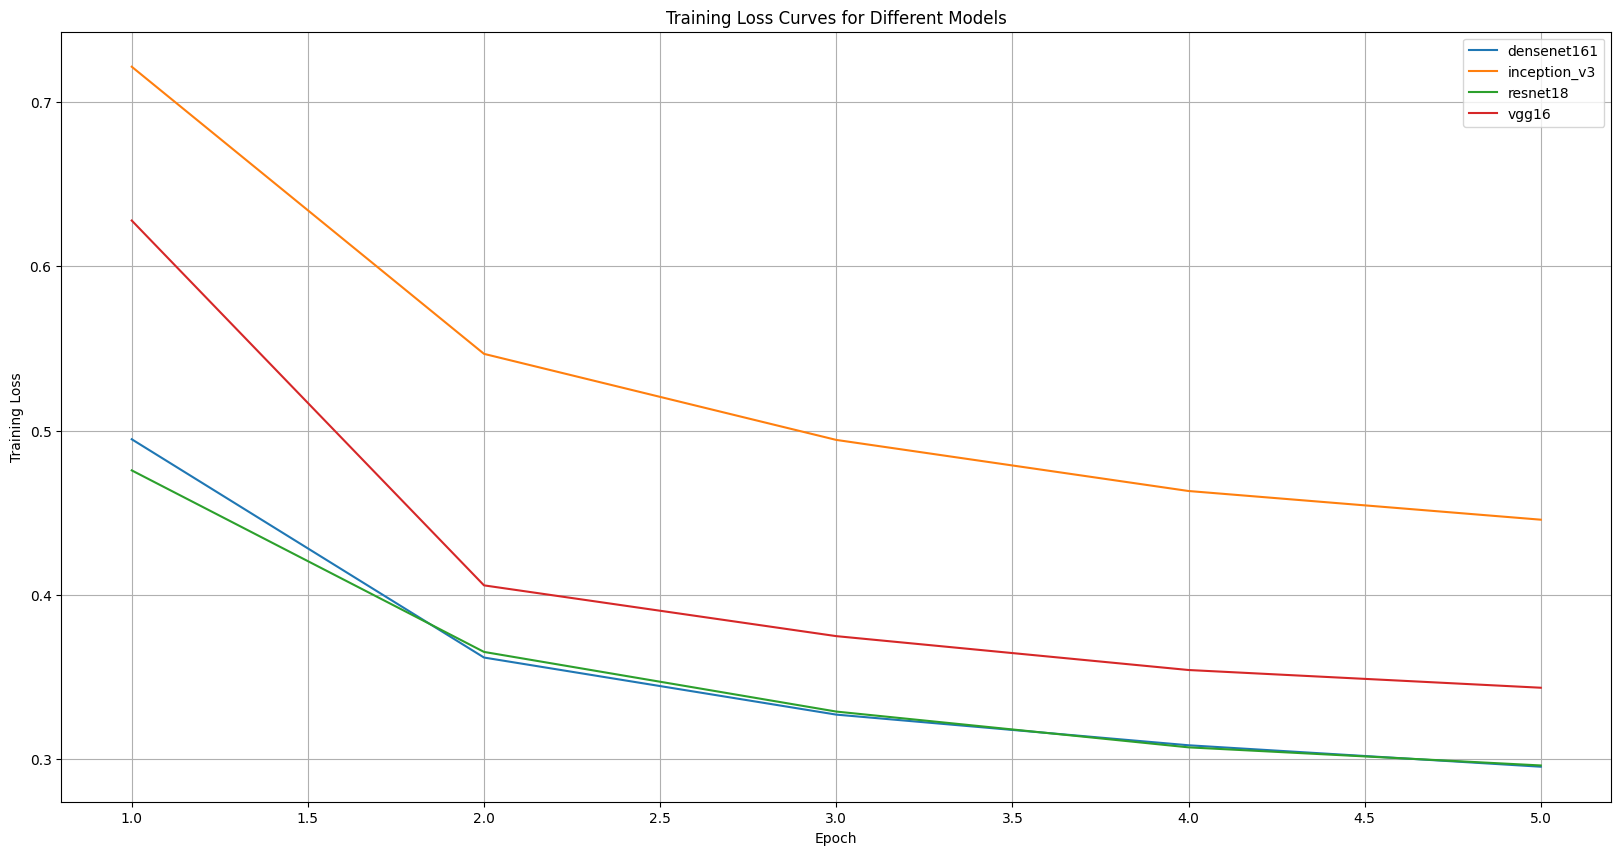

In [12]:
plt.figure(figsize=(20, 10))
for model_name, loss_history in zip(results['Model'], results['Train Loss History']):
    plt.plot(range(1, num_epochs + 1), loss_history, label=model_name)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves for Different Models')
plt.legend()
plt.grid(True)
plt.show()

# **Dataset Hymenoptera**

In [22]:
import kagglehub

path = kagglehub.dataset_download("ajayrana/hymenoptera-data")

In [23]:
learning_rate = .0005
num_epochs = 50
image_size = (300, 300)
batch_size = 8

# **Prepairing datasets**

In [24]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
])


train_dataset = tv.datasets.ImageFolder(
    root=os.path.join(path, 'hymenoptera_data/train'),
    transform=transform
)

test_dataset = tv.datasets.ImageFolder(
    root=os.path.join(path, 'hymenoptera_data/val'),
    transform=transform
)


train_class_counts = Counter(train_dataset.targets)
class_weights = [1. / train_class_counts[i] for i in range(len(train_class_counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float)
sample_weights = torch.tensor([class_weights[label] for label in train_dataset.targets], dtype=torch.float)

sample_weights = sample_weights / sample_weights.sum()

train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_dataset),
    replacement=True
)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
len_dataset = train_dataset.__len__()
total_steps = len_dataset // batch_size
num_classes = train_dataset.classes.__len__()

In [27]:
print(train_dataset.classes[:15])
print(train_dataset.classes.__len__())
print(train_dataset.targets[:15])
print(train_dataset.targets.__len__())
print(train_dataset[0][0].shape)

['ants', 'bees']
2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
244
torch.Size([3, 300, 300])


# **Learning Models**

**Requires gradients is False**

In [17]:
model_names = ["densenet161", 'inception_v3', "resnet18", "vgg16"]
results_no_grad = defaultdict(list)

start_time = time.time()

for model_name in model_names:
    print(f"\nTraining {model_name}...")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model = get_model(model_name, num_classes)

    loss_history = train_model(model, train_loader, num_epochs, model_name)
    test_loss, test_accuracy = test_model(model, test_loader, model_name)

    save_model(model, model_name, name_data="hymenoptera")

    results_no_grad['Dataset'].append("hymenoptera")
    results_no_grad['Model'].append(model_name)
    results_no_grad['Test Loss'].append(test_loss)
    results_no_grad['Test Accuracy'].append(test_accuracy)
    results_no_grad['Train Loss History'].append(loss_history)

    save_results_to_json(results_no_grad, filename="results_without_grad_hymenoptera.json")

print(f'Elapsed time {time.time() - start_time}')        


Training densenet161...
Step 0. time since epoch: 0.106.
Step 15. time since epoch: 1.518.
Step 30. time since epoch: 2.930.
Time 2.9299378395080566 sec, densenet161 Epoch [1/50], Loss: 0.7037, Accuracy: 55.33%
Step 0. time since epoch: 0.091.
Step 15. time since epoch: 1.470.
Step 30. time since epoch: 2.827.
Time 2.8271677494049072 sec, densenet161 Epoch [2/50], Loss: 0.6808, Accuracy: 61.48%
Step 0. time since epoch: 0.099.
Step 15. time since epoch: 1.552.
Step 30. time since epoch: 2.889.
Time 2.889263868331909 sec, densenet161 Epoch [3/50], Loss: 0.6135, Accuracy: 67.62%
Step 0. time since epoch: 0.092.
Step 15. time since epoch: 1.470.
Step 30. time since epoch: 2.843.
Time 2.842665910720825 sec, densenet161 Epoch [4/50], Loss: 0.5872, Accuracy: 68.85%
Step 0. time since epoch: 0.093.
Step 15. time since epoch: 1.495.
Step 30. time since epoch: 2.846.
Time 2.8465707302093506 sec, densenet161 Epoch [5/50], Loss: 0.5463, Accuracy: 75.41%
Step 0. time since epoch: 0.093.
Step 15. 

**Requires gradients is True**

In [18]:
model_names = ["densenet161", 'inception_v3', "resnet18", "vgg16"]
results_grad = defaultdict(list)

start_time = time.time()

for model_name in model_names:
    print(f"\nTraining {model_name}...")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model = get_model(model_name, num_classes, requires_grad=True)

    loss_history = train_model(model, train_loader, num_epochs, model_name)
    test_loss, test_accuracy = test_model(model, test_loader, model_name)

    save_model(model, model_name, name_data="hymenoptera")

    results_grad['Dataset'].append("hymenoptera")
    results_grad['Model'].append(model_name)
    results_grad['Test Loss'].append(test_loss)
    results_grad['Test Accuracy'].append(test_accuracy)
    results_grad['Train Loss History'].append(loss_history)

    save_results_to_json(results_grad, filename="results_with_grad_hymenoptera.json")

print(f'Elapsed time {time.time() - start_time}')        


Training densenet161...
Step 0. time since epoch: 0.238.
Step 15. time since epoch: 3.584.
Step 30. time since epoch: 6.843.
Time 6.843419790267944 sec, densenet161 Epoch [1/50], Loss: 0.7140, Accuracy: 59.02%
Step 0. time since epoch: 0.222.
Step 15. time since epoch: 3.553.
Step 30. time since epoch: 6.811.
Time 6.811832427978516 sec, densenet161 Epoch [2/50], Loss: 0.6656, Accuracy: 61.89%
Step 0. time since epoch: 0.225.
Step 15. time since epoch: 3.540.
Step 30. time since epoch: 6.743.
Time 6.743523597717285 sec, densenet161 Epoch [3/50], Loss: 0.6285, Accuracy: 72.54%
Step 0. time since epoch: 0.220.
Step 15. time since epoch: 3.532.
Step 30. time since epoch: 6.731.
Time 6.73134183883667 sec, densenet161 Epoch [4/50], Loss: 0.6333, Accuracy: 67.62%
Step 0. time since epoch: 0.220.
Step 15. time since epoch: 3.561.
Step 30. time since epoch: 6.767.
Time 6.767190456390381 sec, densenet161 Epoch [5/50], Loss: 0.5763, Accuracy: 72.54%
Step 0. time since epoch: 0.224.
Step 15. time

# **Get Result**

In [19]:
df = pd.DataFrame({
    'Model': results_no_grad['Model'],
    'Test Loss': [f"{x:.4f}" for x in results_no_grad['Test Loss']],
    'Test Accuracy (%)': [f"{x:.2f}" for x in results_no_grad['Test Accuracy']]
})
print("\nResults Table:")
print(df)


Results Table:
          Model Test Loss Test Accuracy (%)
0   densenet161    0.4097             81.70
1  inception_v3    0.5449             71.90
2      resnet18    0.6674             62.75
3         vgg16    1.2199             69.93


In [20]:
df = pd.DataFrame({
    'Model': results_grad['Model'],
    'Test Loss': [f"{x:.4f}" for x in results_grad['Test Loss']],
    'Test Accuracy (%)': [f"{x:.2f}" for x in results_grad['Test Accuracy']]
})
print("\nResults Table:")
print(df)


Results Table:
          Model Test Loss Test Accuracy (%)
0   densenet161    0.5743             77.78
1  inception_v3    0.4488             79.74
2      resnet18    0.6466             79.74
3         vgg16    0.7069             45.75


# **Visualize result**

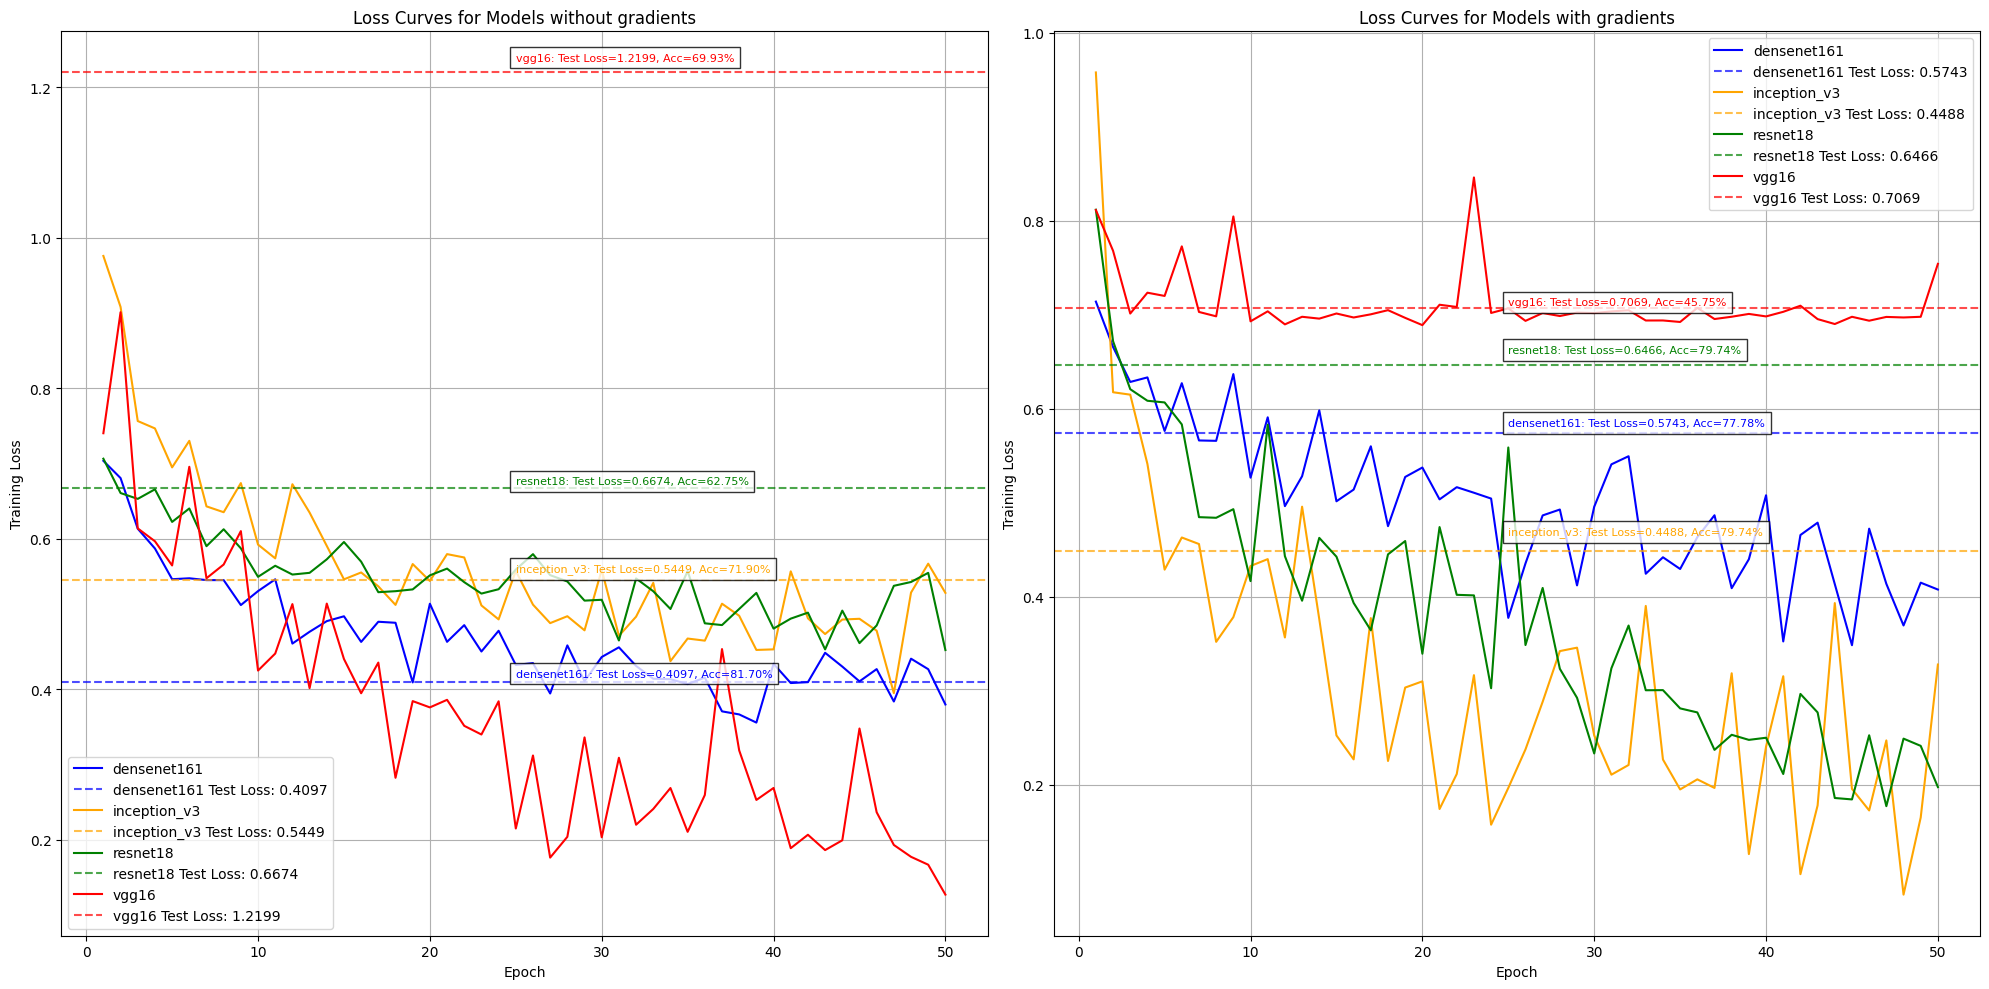

In [21]:
colors = ['blue', 'orange', 'green', 'red'] 

plt.figure(figsize=(20, 10))

# Models with requires_grad=True
plt.subplot(1, 2, 1)
color_idx = 0
for i, (model_name, loss_history, test_loss, test_accuracy) in enumerate(zip(
    results_no_grad['Model'], results_no_grad['Train Loss History'], results_no_grad['Test Loss'], results_no_grad['Test Accuracy']
)):
    plt.plot(range(1, num_epochs + 1), loss_history, label=model_name, color=colors[color_idx % len(colors)])
        
    plt.axhline(
        y=test_loss,
        linestyle='--',
        alpha=.7,
        color=colors[color_idx % len(colors)],
        label=f'{model_name} Test Loss: {test_loss:.4f}'
    )
        
    plt.text(
        x=num_epochs * .5,
        y=test_loss + .02 * (max(loss_history) - min(loss_history)),
        s=f'{model_name}: Test Loss={test_loss:.4f}, Acc={test_accuracy:.2f}%',
        fontsize=8,
        color=colors[color_idx % len(colors)],
        bbox=dict(facecolor='white', alpha=.8)
    )
    color_idx += 1   

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Loss Curves for Models without gradients')
plt.legend()
plt.grid(True)

# Models with requires_grad=False
plt.subplot(1, 2, 2)
color_idx = 0
for i, (model_name, loss_history, test_loss, test_accuracy) in enumerate(zip(
    results_grad['Model'], results_grad['Train Loss History'], results_grad['Test Loss'], results_grad['Test Accuracy']
)):
    plt.plot(range(1, num_epochs + 1), loss_history, label=model_name, color=colors[color_idx % len(colors)])
        
    plt.axhline(
        y=test_loss,
        linestyle='--',
        alpha=.7,
        color=colors[color_idx % len(colors)],
        label=f'{model_name} Test Loss: {test_loss:.4f}'
    )
        
    plt.text(
        x=num_epochs * .5,
        y=test_loss + .02 * (max(loss_history) - min(loss_history)),
        s=f'{model_name}: Test Loss={test_loss:.4f}, Acc={test_accuracy:.2f}%',
        fontsize=8,
        color=colors[color_idx % len(colors)],
        bbox=dict(facecolor='white', alpha=.8)
    )
    color_idx += 1  

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Loss Curves for Models with gradients')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
def visualize_predictions(model, data_loader, class_names, device, num_images=10):
    model.eval()
    
    all_images = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            all_images.append(images)
            all_labels.append(labels)
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    total_images = len(all_images)
    indices = np.random.choice(total_images, size=min(num_images, total_images), replace=False)
    
    images = all_images[indices].to(device)
    labels = all_labels[indices].to(device)
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
    axes = axes.ravel()
    
    for i in range(len(indices)):
        img = images[i].cpu().numpy().transpose(1, 2, 0)

        true_label = class_names[labels[i].item()]
        pred_label = class_names[predicted[i].item()]
        probs = probabilities[i].cpu().numpy()

        axes[i].imshow(img, cmap=None)
        axes[i].set_title(
            f"True: {true_label}\nPredicted: {pred_label}\n"
            f"P({class_names[0]}): {probs[0]:.2f}, P({class_names[1]}): {probs[1]:.2f}",
            fontsize=10
        )
        axes[i].axis('off')

    for j in range(len(indices), len(axes)):
        axes[j].axis('off')

    plt.show()

In [8]:
class_names = {v: k for k, v in train_dataset.class_to_idx.items()}
class_names

{0: 'ants', 1: 'bees'}

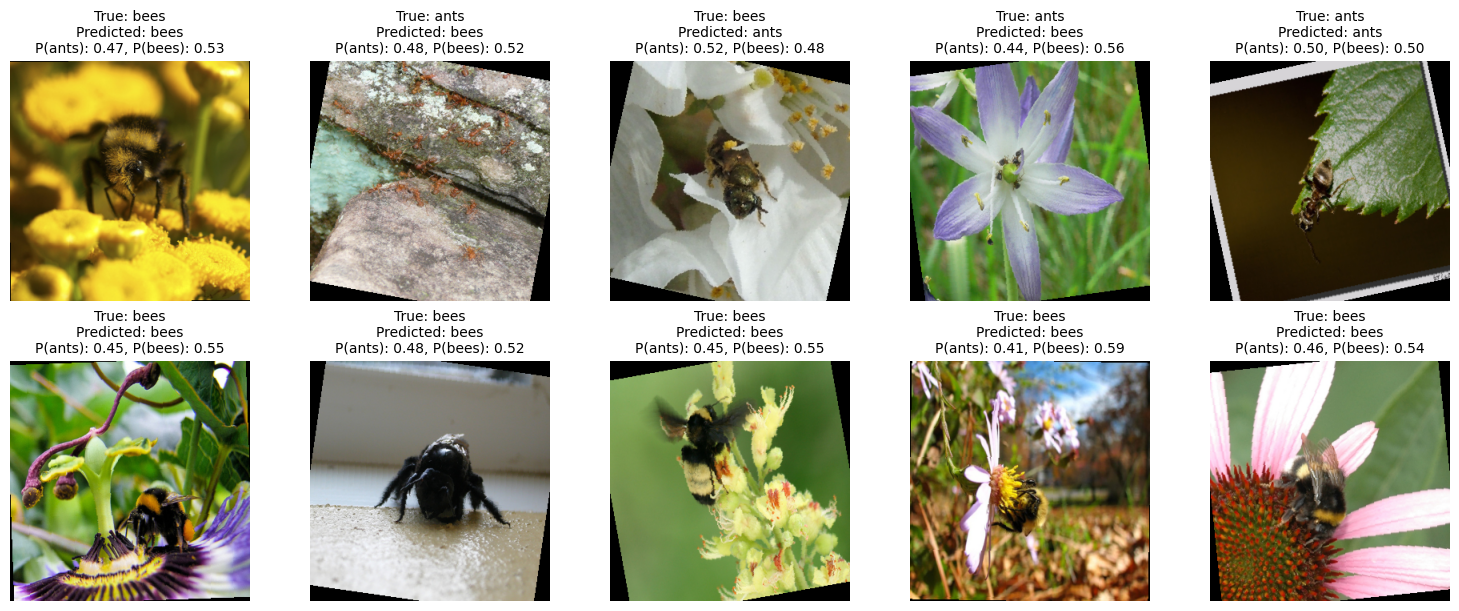

In [25]:
visualize_predictions(get_model('densenet161', num_classes, requires_grad=True), test_loader, class_names, device, num_images=10)